In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_block_count_latency_device = pd.read_csv("block_count_latency_device.csv")
df_read_bytes = pd.read_csv("read_bytes.csv")
df_write_bytes = pd.read_csv("write_bytes.csv")


df_baseline_block_count_latency_device= pd.read_csv("../../baseline/IO related/block_count_latency_device.csv")
df_baseline_read_bytes= pd.read_csv("../../baseline/IO related/read_bytes.csv")
df_baseline_write_bytes = pd.read_csv("../../baseline/IO related/write_bytes.csv")


df_block_count_latency_device["source"] = "NETLOSS"
df_read_bytes["source"] = "NETLOSS"
df_write_bytes["source"] = "NETLOSS"

df_baseline_block_count_latency_device["source"] = "BASELINE"
df_baseline_read_bytes["source"] = "BASELINE"
df_baseline_write_bytes["source"] = "BASELINE"


df_block_count_latency_device["Time"] = pd.to_datetime(df_block_count_latency_device["Time"])
df_read_bytes["Time"] = pd.to_datetime(df_read_bytes["Time"])
df_write_bytes["Time"] = pd.to_datetime(df_write_bytes["Time"])

df_baseline_block_count_latency_device["Time"] = pd.to_datetime(df_baseline_block_count_latency_device["Time"])
df_baseline_read_bytes["Time"] = pd.to_datetime(df_baseline_read_bytes["Time"])
df_baseline_write_bytes["Time"] = pd.to_datetime(df_baseline_write_bytes["Time"])

df_block_count_latency_device["Minutes"] = (df_block_count_latency_device["Time"] - df_block_count_latency_device["Time"].min()).dt.total_seconds() / 60
df_baseline_block_count_latency_device["Minutes"] = (df_baseline_block_count_latency_device["Time"] - df_baseline_block_count_latency_device["Time"].min()).dt.total_seconds() / 60


delay = 30
duration = 50

## block count latency device

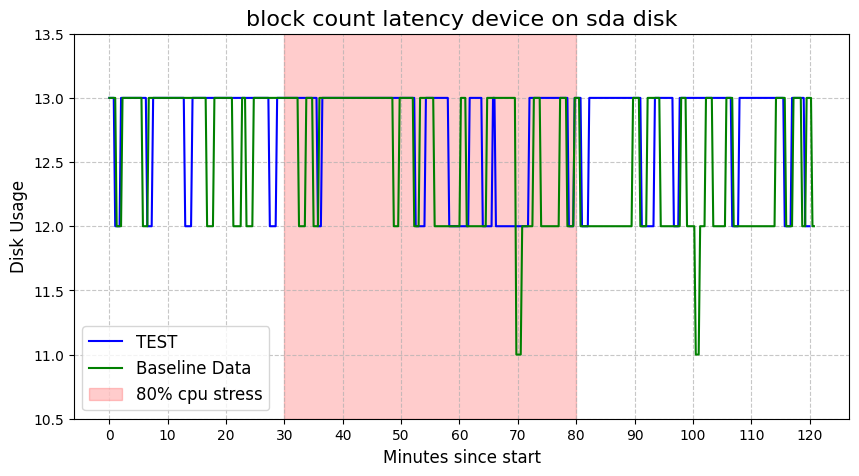

In [13]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(df_block_count_latency_device["Minutes"], df_block_count_latency_device["disk sda"], 
         label="TEST", color='blue', linewidth=1.5)
plt.plot(df_baseline_block_count_latency_device["Minutes"], df_baseline_block_count_latency_device["disk sda"], 
         label="Baseline Data", color='green', linewidth=1.5)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.title("block count latency device on sda disk", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Disk Usage", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(10.5, 13.5)
plt.legend(loc='best', fontsize=12)
plt.xticks(np.arange(0, max(df_block_count_latency_device["Minutes"].max(), 
                           df_baseline_block_count_latency_device["Minutes"].max())+1, 10))

plt.show()

## read bytes

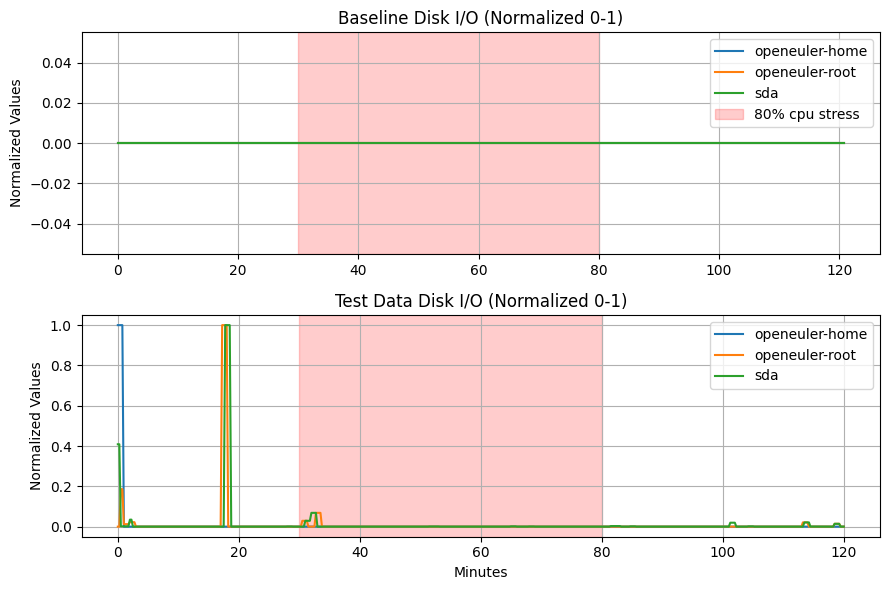

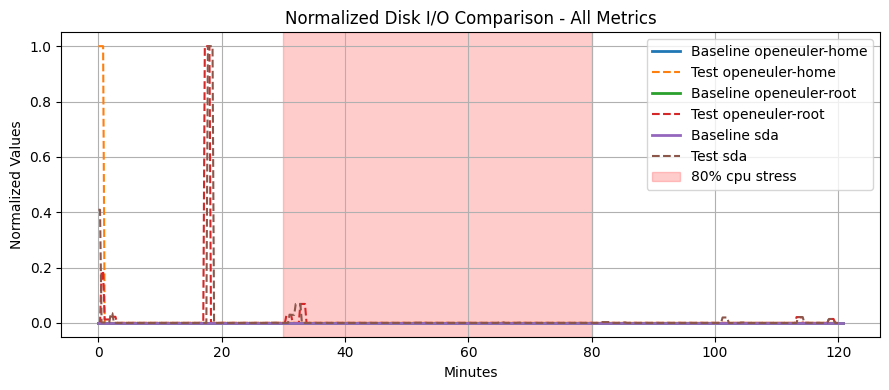

In [14]:
df_read_bytes["Minutes"] = (df_read_bytes["Time"] - df_read_bytes["Time"].min()).dt.total_seconds() / 60
df_baseline_read_bytes["Minutes"] = (df_baseline_read_bytes["Time"] - df_baseline_read_bytes["Time"].min()).dt.total_seconds() / 60

delay = 30  # 30 minutes (1800 seconds)
duration = 50  # 50 minutes (3000 seconds)

# Get columns to analyze
cols = ['openeuler-home', 'openeuler-root', 'sda']

# Create normalization function
def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

# Normalize the data
df_baseline_norm = normalize_df(df_baseline_read_bytes, cols)
df_read_norm = normalize_df(df_read_bytes, cols)

# Create figure for normalized line plots - one for each dataset
plt.figure(figsize=(9, 6))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline Disk I/O (Normalized 0-1)")
plt.ylabel("Normalized Values")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.grid(True)
plt.legend(loc='upper right')

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cols:
    plt.plot(df_read_norm ["Minutes"], df_read_norm [col], label=col)
plt.title("Test Data Disk I/O (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized Values")
plt.grid(True)
plt.legend(loc='upper right')
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.tight_layout()

# Create a separate figure for all columns comparison
plt.figure(figsize=(9, 4))
for col in cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=f"Baseline {col}", linewidth=2)
    plt.plot(df_read_norm ["Minutes"], df_read_norm [col], label=f"Test {col}", linewidth=1.5, linestyle='--')
plt.title("Normalized Disk I/O Comparison - All Metrics")
plt.xlabel("Minutes")
plt.ylabel("Normalized Values")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.grid(True)
plt.legend()
plt.tight_layout()

## write bytes

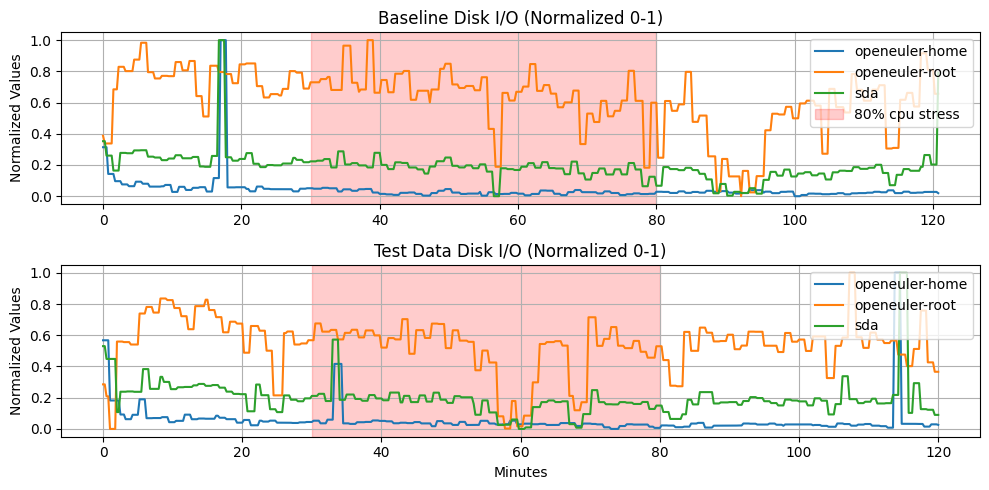

In [15]:
df_write_bytes["Minutes"] = (df_write_bytes["Time"] - df_write_bytes["Time"].min()).dt.total_seconds() / 60
df_baseline_write_bytes["Minutes"] = (df_baseline_write_bytes["Time"] - df_baseline_write_bytes["Time"].min()).dt.total_seconds() / 60

delay = 30  
duration = 50  

cols = ['openeuler-home', 'openeuler-root', 'sda']

def normalize_df(df, columns):
    df_norm = df.copy()
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val > min_val:
            df_norm[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df_norm[col] = 0
    return df_norm

df_baseline_norm = normalize_df(df_baseline_write_bytes, cols)
df_write_bytes_norm= normalize_df(df_write_bytes, cols)

plt.figure(figsize=(10, 5))

# Top subplot for baseline
plt.subplot(2, 1, 1)
for col in cols:
    plt.plot(df_baseline_norm["Minutes"], df_baseline_norm[col], label=col)
plt.title("Baseline Disk I/O (Normalized 0-1)")
plt.ylabel("Normalized Values")
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.grid(True)
plt.legend(loc='upper right')

# Bottom subplot for test
plt.subplot(2, 1, 2)
for col in cols:
    plt.plot(df_write_bytes_norm["Minutes"], df_write_bytes_norm[col], label=col)
plt.title("Test Data Disk I/O (Normalized 0-1)")
plt.xlabel("Minutes")
plt.ylabel("Normalized Values")
plt.grid(True)
plt.legend(loc='upper right')
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="80% cpu stress")
plt.tight_layout()